# 一、ActionNode基础
## 1.1 官方解释
在MG框架0.5版本中，新增加了ActionNode类，为Agent的动作执行提供更强的能力
ActionNode可以被视为一组动作树，根据类内定义，一个动作树的父节点可以访问所有的子动作节点；也就是说，定义了一个完整的动作树之后，可以从父节点按树的结构顺序执行每一个子动作节点。因此，动作的执行也可以突破0.4版本框架中，需要在Role的_react内循环执行的限制，达到更好的CoT效果。

## 1.2 博主的理解
如下图，ActionNode需要内置在Action中使用，之前可能是Action就是一个动作，执行完一个就执行完下一个。有了ActionNode后，Action就不只是一个动作，而可能是一系列动作。这一系列动作可以组织成链式结构，或者树状结构或者更复杂的结构。

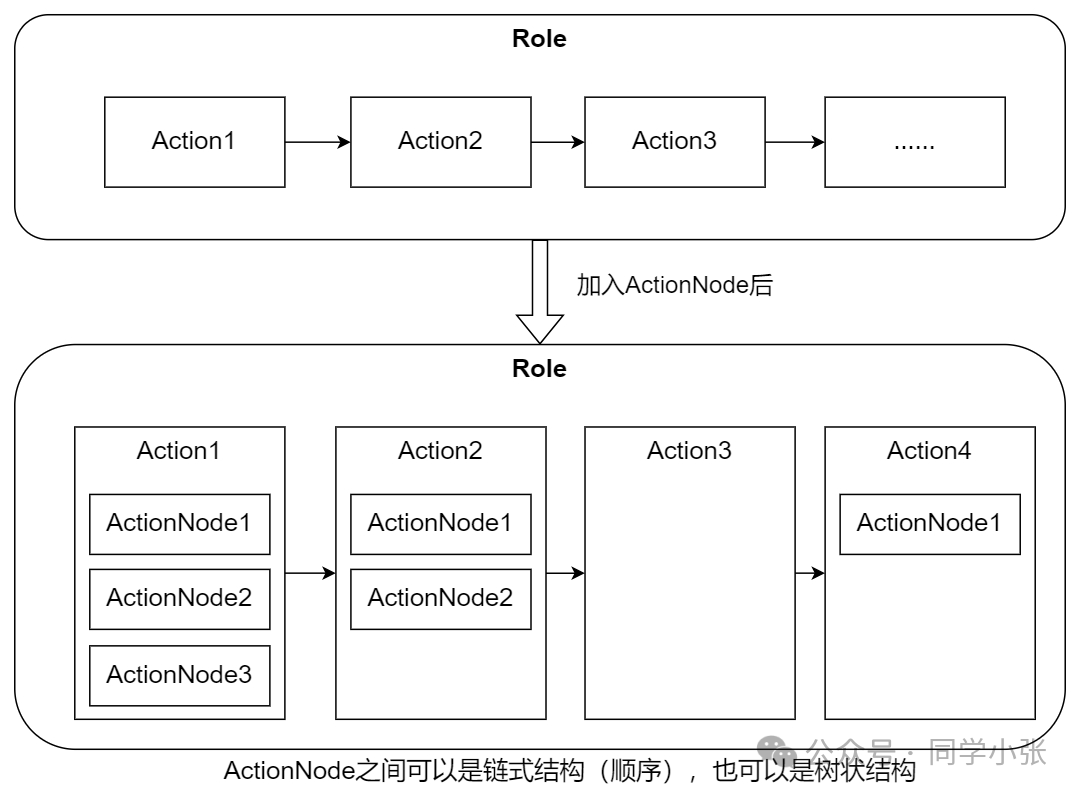

## 1.3 ActionNode的数据结构

In [ ]:
schema: str  # raw/json/markdown, default: ""

# Action Context
context: str  # all the context, including all necessary info
llm: BaseLLM  # LLM with aask interface
children: dict[str, "ActionNode"]

# Action Input
key: str  # Product Requirement / File list / Code
expected_type: Type  # such as str / int / float etc.
# context: str  # everything in the history.
instruction: str  # the instructions should be followed.
example: Any  # example for In Context-Learning.

# Action Output
content: str
instruct_content: BaseModel

其中几个重要的成员变量（以我目前浅显使用过的例子来看）：

instruction：一般是prompt的部分内容

key：一般是ActionNode的名字

schema：指定该ActionNode的输出格式，指定为json或markdown之后会有严格的校验

expected_type：期望返回格式，例如str

example：类似prompt中的few-shot，给几个期望输出的例子

## 1.4 如何使用ActionNode
下面是官方教程给的例子：

In [ ]:
# 定义单个子节点ActionNode
UI_DESIGN_DESC = ActionNode(
    key="UI Design Desc",
    expected_type=str,
    instruction="place the design objective here",
    example="Snake games are classic and addictive games with simple yet engaging elements. Here are the main elements"
    " commonly found in snake games",
)

# 定义完所有ActionNode之后，将其存放在一个List里面
NODES = [
    UI_DESIGN_DESC,
    SELECTED_ELEMENTS,
    HTML_LAYOUT,
    CSS_STYLES,
    ANYTHING_UNCLEAR,
]

# 将上述List的所有子节点传入父节点UI_DESIGN_NODE中
UI_DESIGN_NODE = ActionNode.from_children("UI_DESIGN", NODES)

从上面代码看到，使用ActionNode的步骤很简单，如下

（1）定义一系列ActionNode

（2）根据一系列ActionNode构造父ActionNode

之后，在Action.run方法中，调用父节点的执行方法fill，获取所有子节点按顺序执行之后的结果

In [ ]:
ui_describe = await UI_DESIGN_NODE.fill(prompt)

上面我重点标出了"在Action.run方法中"，说明ActionNode一定是依附在Action中运行的，在Action外不能独立运行？

# 二、ActionNode简单实战
上面了解了ActionNode的定义方法，以及运行fill函数，下面以一个简单的例子，实战一下。实战内容为 《MetaGPT智能体开发入门》课程中的例子：打印前10个斐波那契数列的数字，实现内容如下：

* （1）LLM要能以特定的可解析的格式来返回斐波那契数列

* （2）通过格式解析实现逐个打印数字的效果。

不重要：斐波那契数列是一个数列，每个数都是前两个数的和，通常以0和1开始

## 2.1 思考并返回特定格式的数字
将第一个实现内容（LLM要能以特定的可解析的格式来返回斐波那契数列）拆解：

* （1）思考前10个斐波那契数列的数字是什么

* （2）思考到的数字按特定格式输出

这就可以用两个ActionNode来实现。下面我们具体来实现。

2.1.1 定义两个ActionNode

In [ ]:
# 将思考斐波那契数列的10个数字作为prompt输入，在这里我们将“思考需要生成的数字列表”作为命令（instruction）写入
# 将期望返回格式（expected_type）设置为str，无需设置例子（example）
SIMPLE_THINK_NODE = ActionNode(
    key="Simple Think Node",
    expected_type=str,
    instruction="""
            Think about what list of numbers you need to generate
            """,
    example=""
)

# 在这里通过命令（instruction）来规定需要生成的数字列表格式，提供例子（example）来帮助LLM理解
SIMPLE_CHECK_NODE = ActionNode(
    key="Simple CHECK Node",
    expected_type=str,
    instruction="""
            Please provide the number list for me, strictly following the following requirements:
            1. Answer strictly in the list format like [1,2,3,4]
            2. Do not have extra spaces or line breaks.
            Return the list here:
            """,
    example="[1,2,3,4]"
            "[4,5,6]",
 )

2.1.2 为这两个动作节点设置一个父节点

In [ ]:
class THINK_NODES(ActionNode):
    def __init__(self, name="Think Nodes", expected_type=str, instruction="", example=""):
        super().__init__(key=name, expected_type=expected_type, instruction=instruction, example=example)
        self.add_children([SIMPLE_THINK_NODE, SIMPLE_CHECK_NODE])    # 初始化过程，将上面实现的两个子节点加入作为THINK_NODES类的子节点

    async def fill(self, context, llm, schema="raw", mode="auto", strgy="complex"):
        self.set_llm(llm)
        self.set_context(context)
        if self.schema:
            schema = self.schema

        if strgy == "simple":
            return await self.simple_fill(schema=schema, mode=mode)
        elif strgy == "complex":
            # 这里隐式假设了拥有children
            child_context = context    # 输入context作为第一个子节点的context
            for _, i in self.children.items():
                i.set_context(child_context)    # 为子节点设置context
                child = await i.simple_fill(schema=schema, mode=mode)
                child_context = child.content    # 将返回内容（child.content）作为下一个子节点的context

            self.content = child_context    # 最后一个子节点返回的内容设置为父节点返回内容（self.content）
            return self

为什么需要设置父节点？

* ActionNode的 fill 方法，有一个参数叫“strgy”，当我们将这个参数设置为“complex”时，这个方法会按顺序执行每一个子节点，并将上一个子节点返回的内容作为下一个子节点的prompt。为了将两个动作节点串联起来，形成一个简单的CoT效果，我们需要设置一个父节点。

2.1.3 定义一个Action来承载上面的ActionNode

前文已经说了，ActionNode的运行需要依赖Action的动作，所以这里需要定义一个Action：

In [ ]:
class ThinkAction(Action):
    def __init__(self, name="ThinkAction", context=None, llm=None):
        super().__init__()
        self.node = THINK_NODES()    # 初始化Action时，初始化一个THINK_NODE实例并赋值给self.node

    async def run(self, instruction) -> list:
        PROMPT = """
            You are now a number list generator, follow the instruction {instruction} and
            generate a number list to be printed please.
            """

        prompt = PROMPT.format(instruction=instruction)
        rsp_node = await self.node.fill(context=prompt, llm=self.llm, schema="raw",
                                        strgy="complex")  # 1. 运行子节点，获取返回（返回格式为ActionNode）（注意设置 schema="raw"） 2. 注意strgy为complex，表示执行所有子节点，如果是"simple", 则只会执行父节点本身
        rsp = rsp_node.content  # 获取返回的文本内容，返回的是ActionNode，通过.content来获取实际内容
        rsp_match = self.find_in_brackets(rsp)  # 按列表格式解析返回的文本内容，定位“[”与“]”之间的内容

        try:
            rsp_list = list(map(int, rsp_match[0].split(',')))  # 按列表格式解析返回的文本内容，按“,”对内容进行分割，并形成一个python语法中的列表
            return rsp_list
        except:
            return []

    @staticmethod
    def find_in_brackets(s):
        pattern = r'\[(.*?)\]'
        match = re.findall(pattern, s)
        return match

这个Action的几个重点关注点：

* (1) 初始化中self.node = THINK_NODES()，将ActionNode依附在Action中。

* (2) Action的run方法中执行ActionNode的动作：await self.node.fill(context=prompt, llm=self.llm, schema="raw", strgy="complex")

其中注意schema为"raw"

strgy为“complex”，表示会执行完 `THINK_NODES()`中的所有子节点才会返回

# 2.2 逐个打印数字
上面的程序将前10个数字解析出来并形成了Python中的list数组。下面实现逐个打印的Action

In [ ]:
class SimplePrint(Action):
    input_num: int = 0

    def __init__(self, name="SimplePrint", input_num:int=0):
        super().__init__()
        self.input_num = input_num

    async def run(self):
        print(str(self.input_num) + "\n")
        return str(self.input_num)

# 2.3 实现Role，执行Action
有了Action，需要有个Role执行它。Role的代码和细节注释如下：

In [ ]:
class Printer(Role):

    def __init__(self, name="TXXZ", profile="Printer", goal="Print the number", constraints=""):
        super().__init__()
        self._init_actions([ThinkAction]) ## 1. 将Action加入Role的执行列表

    async def _think(self) -> None:
        """Determine the action"""
        if self.rc.todo is None:
            self._set_state(0)
            return

        if self.rc.state + 1 < len(self.states):
            self._set_state(self.rc.state + 1)
        else:
            self.rc.todo = None

    async def _prepare_print(self, num_list:list) -> Message:
        """Add actions"""
        actions = list()
        for num in num_list: ## 2. 对于Action返回的数组，逐个添加SimplePrint动作
            actions.append(SimplePrint(input_num=num))

        self._init_actions(actions) ## 4. 这里第一个action变成了SimplePrint动作
        self.rc.todo = None ## 3. 为None时，_think函数会回到第一个action执行
        return Message(content=str(num_list))

    async def _act(self) -> Message:
        """Action"""
        todo = self.rc.todo
        if type(todo) is ThinkAction :
            msg = self.rc.memory.get(k=1)[0]
            self.goal = msg.content
            resp = await todo.run(instruction=self.goal) # 7. 个人感觉这里的goal有和没有都没关系，虽然作为prompt传入ThinkAction，但是这里并不是打印Action，与任务无关
            return await self._prepare_print(resp) ## 5. ActionNode都执行完了，返回的是个数组，逐个去添加打印Action

        resp = await todo.run() ## 6. 执行打印Action
        return Message(content=resp, role=self.profile)

    async def _react(self) -> Message:
        while True:
            await self._think()
            if self.rc.todo is None:
                break
            msg = await self._act()
        return msg

# 3. 完整代码和运行效果
## 3.1 完整代码

In [ ]:
# 加载 .env 到环境变量
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

import asyncio
import re

from metagpt.actions.action import Action, ActionNode
from metagpt.logs import logger
from metagpt.roles import Role
from metagpt.schema import Message

# 将思考斐波那契数列的10个数字作为prompt输入，在这里我们将“思考需要生成的数字列表”作为命令（instruction）写入
# 将期望返回格式（expected_type）设置为str，无需设置例子（example）
SIMPLE_THINK_NODE = ActionNode(
    key="Simple Think Node",
    expected_type=str,
    instruction="""
            Think about what list of numbers you need to generate
            """,
    example=""
)

# 在这里通过命令（instruction）来规定需要生成的数字列表格式，提供例子（example）来帮助LLM理解
SIMPLE_CHECK_NODE = ActionNode(
    key="Simple CHECK Node",
    expected_type=str,
    instruction="""
            Please provide the number list for me, strictly following the following requirements:
            1. Answer strictly in the list format like [1,2,3,4]
            2. Do not have extra spaces or line breaks.
            Return the list here:
            """,
    example="[1,2,3,4]"
            "[4,5,6]",
 )


class THINK_NODES(ActionNode):
    def __init__(self, name="Think Nodes", expected_type=str, instruction="", example=""):
        super().__init__(key=name, expected_type=expected_type, instruction=instruction, example=example)
        self.add_children([SIMPLE_THINK_NODE, SIMPLE_CHECK_NODE])    # 初始化过程，将上面实现的两个子节点加入作为THINK_NODES类的子节点

    async def fill(self, context, llm, schema="raw", mode="auto", strgy="complex"):
        self.set_llm(llm)
        self.set_context(context)
        if self.schema:
            schema = self.schema

        if strgy == "simple":
            return await self.simple_fill(schema=schema, mode=mode)
        elif strgy == "complex":
            # 这里隐式假设了拥有children
            child_context = context    # 输入context作为第一个子节点的context
            for _, i in self.children.items():
                i.set_context(child_context)    # 为子节点设置context
                child = await i.simple_fill(schema=schema, mode=mode)
                child_context = child.content    # 将返回内容（child.content）作为下一个子节点的context

            self.content = child_context    # 最后一个子节点返回的内容设置为父节点返回内容（self.content）
            return self


class SimplePrint(Action):
    """
    Action that print the num inputted
    """
    input_num: int = 0

    def __init__(self, name="SimplePrint", input_num:int=0):
        super().__init__()

        self.input_num = input_num

    async def run(self):
        print(str(self.input_num) + "\n")
        return str(self.input_num)

class ThinkAction(Action):
    """
    Action that think
    """

    def __init__(self, name="ThinkAction", context=None, llm=None):
        super().__init__()
        self.node = THINK_NODES()    # 初始化Action时，初始化一个THINK_NODE实例并赋值给self.node

    async def run(self, instruction) -> list:
        PROMPT = """
            You are now a number list generator, follow the instruction {instruction} and
            generate a number list to be printed please.
            """

        prompt = PROMPT.format(instruction=instruction)
        rsp_node = await self.node.fill(context=prompt, llm=self.llm, schema="raw",
                                        strgy="complex")  # 运行子节点，获取返回（返回格式为ActionNode）（注意设置 schema="raw" ）
        rsp = rsp_node.content  # 获取返回的文本内容

        rsp_match = self.find_in_brackets(rsp)  # 按列表格式解析返回的文本内容，定位“[”与“]”之间的内容

        try:
            rsp_list = list(map(int, rsp_match[0].split(',')))  # 按列表格式解析返回的文本内容，按“,”对内容进行分割，并形成一个python语法中的列表

            return rsp_list
        except:
            return []

    @staticmethod
    def find_in_brackets(s):
        pattern = r'\[(.*?)\]'
        match = re.findall(pattern, s)
        return match

class Printer(Role):

    def __init__(self, name="Jerry", profile="Printer", goal="Print the number", constraints=""):
        super().__init__()

        self._init_actions([ThinkAction])
        # self.num_list = list()

    async def _think(self) -> None:
        """Determine the action"""
        # logger.info(self.rc.state)

        if self.rc.todo is None:
            self._set_state(0)
            return

        if self.rc.state + 1 < len(self.states):
            self._set_state(self.rc.state + 1)
        else:
            self.rc.todo = None

    async def _prepare_print(self, num_list:list) -> Message:
        """Add actions"""
        actions = list()

        for num in num_list:
            actions.append(SimplePrint(input_num=num))

        self._init_actions(actions)
        self.rc.todo = None
        return Message(content=str(num_list))

    async def _act(self) -> Message:
        """Action"""
        todo = self.rc.todo

        if type(todo) is ThinkAction :
            msg = self.rc.memory.get(k=1)[0]
            self.goal = msg.content
            resp = await todo.run(instruction=self.goal)
            # logger.info(resp)

            return await self._prepare_print(resp)

        resp = await todo.run()
        # logger.info(resp)

        return Message(content=resp, role=self.profile)

    async def _react(self) -> Message:
        """"""
        while True:
            await self._think()

            if self.rc.todo is None:
                break
            msg = await self._act()

        return msg


async def main():
    msg = "Provide the first 10 numbers of the Fibonacci series"
    role = Printer()
    logger.info(msg)
    result = await role.run(msg)
    logger.info(result)


if __name__ == '__main__':
    asyncio.run(main())

# 3.2 运行效果

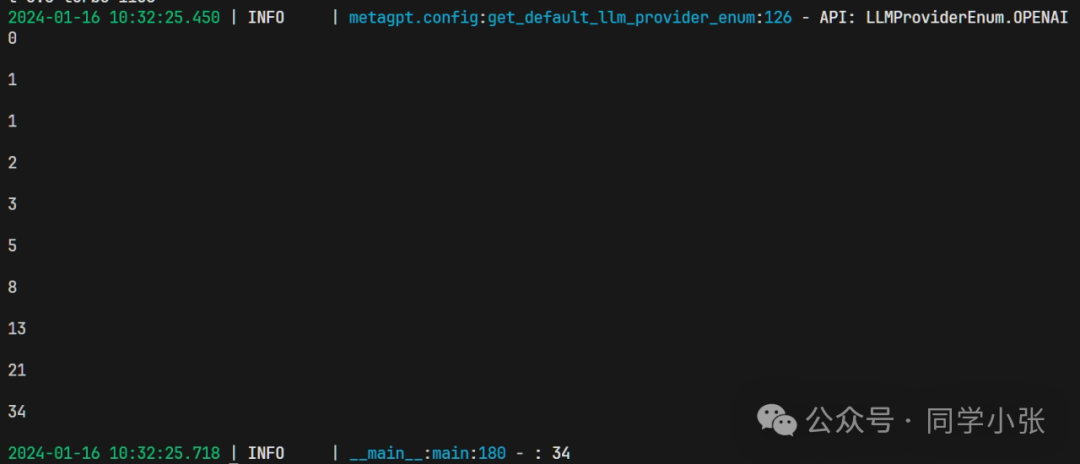

本文代码是经过修改的，可以直接运行。

前提：使用 MetaGPT 0.6+ 的版本，博主这里用的是github最新代码（2024-01-16），源码编译的。